In [1]:
import pandas as pd
import plotly.express as px
import os
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from deep_translator import GoogleTranslator

import pandas as pd
import plotly.express as px
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

date_cols = {
    'olist_orders_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
    ],
    'olist_order_items_dataset.csv': [
        'shipping_limit_date',
    ],
    'olist_order_reviews_dataset.csv': [
        'review_creation_date',
        'review_answer_timestamp',
    ],
    # The following datasets have NO date columns:
    # 'olist_customers_dataset.csv'
    # 'olist_geolocation_dataset.csv'
    # 'olist_order_payments_dataset.csv'
    # 'olist_products_dataset.csv'
    # 'olist_sellers_dataset.csv'
    # 'product_category_name_translation.csv'
}

def read_olist_csv(path):
    """
    Reads an Olist CSV and parses dates for the correct columns.
    Args:
        path (str): Path to the CSV file.
    Returns:
        pd.DataFrame: Loaded dataframe with date columns parsed as datetime.
    """
    # Extract just the filename, e.g., 'olist_orders_dataset.csv'
    filename = os.path.basename(path)
    # Get the correct date columns for this file, or an empty list
    parse_dates = date_cols.get(filename, [])
    # Read the CSV, parsing the specified date columns (if any)
    return pd.read_csv(path, parse_dates=parse_dates)

df_orders           = read_olist_csv('../data/original_data/olist_orders_dataset.csv')
df_customers        = read_olist_csv('../data/original_data/olist_customers_dataset.csv')
df_order_items      = read_olist_csv('../data/original_data/olist_order_items_dataset.csv')
df_order_payments   = read_olist_csv('../data/original_data/olist_order_payments_dataset.csv')
df_reviews          = read_olist_csv('../data/original_data/olist_order_reviews_dataset.csv')
df_products         = read_olist_csv('../data/original_data/olist_products_dataset.csv')
df_prod_cat_tr      = read_olist_csv('../data/original_data/product_category_name_translation.csv')
df_sellers          = read_olist_csv('../data/original_data/olist_sellers_dataset.csv')
df_geolocation      = read_olist_csv('../data/original_data/olist_geolocation_dataset.csv')

# Cleaned dataset
df_orders_delivered_clean       = read_olist_csv('../data/cleaned_data/olist_orders_dataset.csv')
df_geolocation_clean            = read_olist_csv('../data/cleaned_data/olist_geolocation_dataset.csv')
df_sellers_cleaned              = read_olist_csv('../data/cleaned_data/olist_sellers_dataset.csv')
df_products_cleaned             = read_olist_csv('../data/cleaned_data/olist_products_dataset.csv')
df_order_items_delivered_clean  = read_olist_csv('../data/cleaned_data/olist_order_items_dataset.csv')
df_order_payments_delivered_clean = read_olist_csv('../data/cleaned_data/olist_order_payments_dataset.csv')

In [2]:
# Load the reviews dataset:
df_reviews.head(10)

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   
5  15197aa66ff4d0650b5434f1b46cda19  b18dcdf73be66366873cd26c5724d1dc   
6  07f9bee5d1b850860defd761afa7ff16  e48aa0d2dcec3a2e87348811bcfdf22b   
7  7c6400515c67679fbee952a7525281ef  c31a859e34e3adac22f376954e19b39d   
8  a3f6f7f6f433de0aefbb97da197c554c  9c214ac970e84273583ab523dfafd09b   
9  8670d52e15e00043ae7de4c01cc2fe06  b9bf720beb4ab3728760088589c62129   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   
5             1                  NaN   
6             5                  NaN   
7             5                  NaN   
8             5                  NaN   
9             4            recomendo   

                              review_comment_message review_creation_date  \
0                                                NaN           2018-01-18   
1                                                NaN           2018-03-10   
2                                                NaN           2018-02-17   
3              Recebi bem antes do prazo estipulado.           2017-04-21   
4  Parabéns lojas lannister adorei comprar pela I...           2018-03-01   
5                                                NaN           2018-04-13   
6                                                NaN           2017-07-16   
7                                                NaN           2018-08-14   
8                                                NaN           2017-05-17   
9  aparelho eficiente. no site a marca do aparelh...           2018-05-22   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53  
5     2018-04-16 00:39:37  
6     2017-07-18 19:30:34  
7     2018-08-14 21:36:06  
8     2017-05-18 12:05:37  
9     2018-05-23 16:45:47

| Column Name               | Description                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| `review_id`              | Unique identifier for each review.                                          |
| `order_id`               | Identifier linking the review to a specific order.                          |
| `review_score`           | Numerical score given by the customer (1 to 5, where 1 = worst, 5 = best).  |
| `review_comment_title`   | Optional short title provided by the customer in their review.              |
| `review_comment_message` | Optional detailed review message written by the customer.                   |
| `review_creation_date`   | Date when the customer submitted the review.                                |
| `review_answer_timestamp`| Date and time when the seller or platform responded to the review.          |

In [3]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB


In [4]:
df_reviews.describe()

review_score           review_creation_date  \
count  99224.000000                          99224   
mean       4.086421  2018-01-12 20:49:23.948238336   
min        1.000000            2016-10-02 00:00:00   
25%        4.000000            2017-09-23 00:00:00   
50%        5.000000            2018-02-02 00:00:00   
75%        5.000000            2018-05-16 00:00:00   
max        5.000000            2018-08-31 00:00:00   
std        1.347579                            NaN   

             review_answer_timestamp  
count                          99224  
mean   2018-01-16 00:23:56.977938688  
min              2016-10-07 18:32:28  
25%    2017-09-27 01:53:27.249999872  
50%       2018-02-04 22:41:47.500000  
75%       2018-05-20 12:11:21.500000  
max              2018-10-29 12:27:35  
std                              NaN

In [5]:
summary = []

for col in df_reviews.columns:
    unique_vals = df_reviews[col].dropna().unique()
    summary.append({
        'Column': col,
        'Unique Count': len(unique_vals),
        'Unique Values': unique_vals
    })

df_summary = pd.DataFrame(summary)
df_summary

Column  Unique Count  \
0                review_id         98410   
1                 order_id         98673   
2             review_score             5   
3     review_comment_title          4527   
4   review_comment_message         36159   
5     review_creation_date           636   
6  review_answer_timestamp         98248   

                                       Unique Values  
0  [7bc2406110b926393aa56f80a40eba40, 80e641a11e5...  
1  [73fc7af87114b39712e6da79b0a377eb, a548910a1c6...  
2                                    [4, 5, 1, 3, 2]  
3  [recomendo, Super recomendo, Não chegou meu pr...  
4  [Recebi bem antes do prazo estipulado., Parabé...  
5  [2018-01-18 00:00:00, 2018-03-10 00:00:00, 201...  
6  [2018-01-18 21:46:59, 2018-03-11 03:05:13, 201...

In [6]:
# Filter reviews to include only those from delivered orders
delivered_order_ids = df_orders_delivered_clean['order_id'].unique()

# Filter reviews to only include reviews from delivered orders
df_reviews_delivered = df_reviews[df_reviews['order_id'].isin(delivered_order_ids)]

# Display basic info about the filtered dataset
print(f"Total reviews: {len(df_reviews)}")
print(f"Reviews from delivered orders: {len(df_reviews_delivered)}")
print(f"Percentage of reviews from delivered orders: {len(df_reviews_delivered)/len(df_reviews)*100:.2f}%")

# Show the first few rows
df_reviews_delivered.head()

Total reviews: 99224
Reviews from delivered orders: 96166
Percentage of reviews from delivered orders: 96.92%


review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN           2018-01-18   
1                                                NaN           2018-03-10   
2                                                NaN           2018-02-17   
3              Recebi bem antes do prazo estipulado.           2017-04-21   
4  Parabéns lojas lannister adorei comprar pela I...           2018-03-01   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

In [7]:
df_reviews_delivered.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       85018
review_comment_message     57148
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In real-world reviews, it's very common for customers to:

- Write only a message and leave the title blank (most typical)
- Leave just a title (e.g., "Great!" or "Terrible!") without elaborating

But if both review_comment_title and review_comment_message are missing, then there's no actual comment—just a score. These are often not useful for text analysis or NLP.

In [8]:
# Count rows where both title and message are missing:
no_comment_count = df_reviews_delivered[
    df_reviews_delivered['review_comment_title'].isna() &
    df_reviews_delivered['review_comment_message'].isna()
].shape[0]

print(f"Rows with no title and no message: {no_comment_count}")

Rows with no title and no message: 55453


In [9]:
df_reviews_delivered.duplicated().sum()

0

In [10]:
df_reviews_delivered['review_id'].duplicated().sum()

712

In [11]:
df_reviews_delivered_cleaned = df_reviews_delivered.copy().drop_duplicates(
    subset='review_id',
    keep='first'
).reset_index(drop=True)

In [12]:
df_reviews_delivered_cleaned['review_id'].duplicated().sum()

0

In [19]:
df_reviews_delivered_cleaned['order_id'].duplicated().sum()

245

In [25]:
orders_with_multiple_reviews = df_reviews_delivered_cleaned[df_reviews_delivered_cleaned['order_id'].duplicated(keep=False)]
orders_with_multiple_reviews

review_id                          order_id  \
29     540e7bbb2d06cfb7f85f3a88ba7ac97f  cf73e2cb1f4a9480ed70c154da3d954a   
331    a0a641414ff718ca079b3967ef5c2495  169d7e0fd71d624d306f132acd791cbe   
484    505a882ba08a689682a4afc6eb4e5965  1c308eca3f339414a92e518e2a2e5ee9   
744    c5976a5a98e854fb23d7e03c6754ae60  2002ea16e75277eaa0b5d78632048540   
1001   afd9b3d196f0acd81d79d8ccd79c2430  5040757d4e06a4be96d3827b860b4e7c   
...                                 ...                               ...   
93681  d4d5f3dcd2130a28d547b0ec78b2a707  64f2e9aa85911b6a48e3d11ef05b73c7   
94333  41f9e1785dd8ea3b6777220901df3c8e  bee4fbc438d2d48527e812cb6a1c8166   
94762  77f1a000f9f3d97382cf32b6b3bb6e7a  2739713764165279791b394484947e2d   
94914  e28cc2a1bf48c11dbcc990894356bd82  1de86d094f7dd41cca13d246d3b7fd07   
95430  40743b46a0ee86375cedb95e82b78d75  3e93213bb8fdda91186b4018b2fe0030   

       review_score review_comment_title review_comment_message  \
29                5                  NaN                    NaN   
331               5                  NaN                    NaN   
484               2                  NaN                    NaN   
744               5                  NaN                    NaN   
1001              5                  NaN                    NaN   
...             ...                  ...                    ...   
93681             5                  NaN                  otimo   
94333             4                  NaN                    NaN   
94762             5                  NaN                    NaN   
94914             5                  NaN                    NaN   
95430             5      OTIMA EMBALAGEM                    NaN   

      review_creation_date review_answer_timestamp  
29              2018-01-18     2018-01-18 19:12:30  
331             2018-03-04     2018-03-06 20:12:53  
484             2017-12-28     2017-12-31 20:25:02  
744             2017-08-08     2017-08-10 11:11:29  
1001            2017-10-31     2017-11-04 21:12:29  
...                    ...                     ...  
93681           2017-12-09     2017-12-11 11:24:20  
94333           2017-12-16     2017-12-19 17:23:51  
94762           2017-05-16     2017-05-17 00:00:17  
94914           2017-11-15     2017-11-17 05:12:37  
95430           2018-08-08     2018-08-08 16:56:16  

[490 rows x 7 columns]

In [ ]:
df_reviews_delivered_cleaned[df_reviews_delivered_cleaned['order_id'] == '3e93213bb8fdda91186b4018b2fe0030']

review_id                          order_id  \
5448   7168439a7228c5684a494116c1c8da5f  3e93213bb8fdda91186b4018b2fe0030   
95430  40743b46a0ee86375cedb95e82b78d75  3e93213bb8fdda91186b4018b2fe0030   

       review_score review_comment_title  \
5448              5            recomendo   
95430             5      OTIMA EMBALAGEM   

                               review_comment_message review_creation_date  \
5448   embalagem apropriada, entregue dentro do prazo           2018-07-24   
95430                                             NaN           2018-08-08   

      review_answer_timestamp  
5448      2018-07-25 13:00:22  
95430     2018-08-08 16:56:16

In [23]:
df_reviews_delivered_cleaned[df_reviews_delivered_cleaned['order_id'] == 'cf73e2cb1f4a9480ed70c154da3d954a']

review_id                          order_id  \
29    540e7bbb2d06cfb7f85f3a88ba7ac97f  cf73e2cb1f4a9480ed70c154da3d954a   
3038  aa193e76d35950c4ae988237bb36ed2b  cf73e2cb1f4a9480ed70c154da3d954a   

      review_score review_comment_title review_comment_message  \
29               5                  NaN                    NaN   
3038             5                  NaN                    NaN   

     review_creation_date review_answer_timestamp  
29             2018-01-18     2018-01-18 19:12:30  
3038           2018-01-18     2018-01-18 17:36:45

In [26]:
# Group by order_id and check if review scores differ within each group
orders_with_different_scores = orders_with_multiple_reviews.groupby('order_id').filter(
    lambda x: x['review_score'].nunique() > 1
)

# Display the orders with different review scores
if len(orders_with_different_scores) > 0:
    print(f"Found {orders_with_different_scores['order_id'].nunique()} orders with multiple reviews that have different scores")
    # Sort by order_id and review_creation_date to see the chronological order of reviews
    result = orders_with_different_scores.sort_values(['order_id', 'review_creation_date'])
    display(result)
else:
    print("No orders found with multiple reviews that have different scores")

Found 78 orders with multiple reviews that have different scores


review_id                          order_id  \
43625  f543cfa959c3289703f144a32113bd78  04f1827088d972a62224f5203a071500   
41688  c793b25686e244588d4fc71964c95a2c  04f1827088d972a62224f5203a071500   
15294  47746f14e9ac9954d196de1cfb45741e  059bbeb3477ed66fd7e670c3f879009a   
8888   85b0c36f463e19aa709b2ee1446513ce  059bbeb3477ed66fd7e670c3f879009a   
51746  c5f404138d9568bebb5dde204d15b25f  075a544c5f4ed4bb75f82b160465fe76   
...                                 ...                               ...   
28756  4994fe478b3f3ebda4db5988f417b6a4  fa350da9efbba83c2957b629bf6c2c7c   
1127   3c625d52413314975e47e144fbc3cb8e  fd61441ba2a7b57e6342862e779b10b0   
83449  24ad2fc85ec000ba4fbfd9841d9a1972  fd61441ba2a7b57e6342862e779b10b0   
90961  c56a88a404315a0d9e412c1472dda2c4  ff763b73e473d03c321bcd5a053316e8   
26592  5e78482ee783451be6026e5cf0c72de1  ff763b73e473d03c321bcd5a053316e8   

       review_score review_comment_title  \
43625             5                  NaN   
41688             1                  NaN   
15294             2                  NaN   
8888              5                  NaN   
51746             3                  NaN   
...             ...                  ...   
28756             1                  NaN   
1127              5                  NaN   
83449             4                  NaN   
90961             5                  NaN   
26592             3                  NaN   

                                  review_comment_message review_creation_date  \
43625                                                NaN           2017-12-30   
41688                                                NaN           2018-01-07   
15294      Só veio o puxador do lado esquerdo/motorista            2017-08-01   
8888                                                 NaN           2017-08-03   
51746                                                NaN           2018-03-06   
...                                                  ...                  ...   
28756  Não entregaram no prazo, já tá com mais de 30 ...           2017-05-25   
1127                                                 NaN           2017-10-04   
83449       Tem que retirar nos correios, muito incômodo           2017-10-14   
90961                                                NaN           2017-11-01   
26592  Não sei que haverá acontecido os demais chegaram            2017-11-18   

      review_answer_timestamp  
43625     2018-01-03 10:40:06  
41688     2018-01-07 11:14:04  
15294     2017-08-01 20:39:04  
8888      2017-08-04 09:32:59  
51746     2018-03-07 12:32:38  
...                       ...  
28756     2017-05-30 20:22:02  
1127      2017-10-05 18:02:50  
83449     2017-10-16 21:23:28  
90961     2017-11-01 19:55:52  
26592     2017-11-18 09:02:48  

[156 rows x 7 columns]

In [29]:
# Sort by review_creation_date descending so the latest is first
reviews_dedup = (
    df_reviews_delivered_cleaned
    .sort_values('review_creation_date', ascending=False)
    .drop_duplicates(subset='order_id', keep='first')
    .reset_index(drop=True)
)

reviews_dedup['order_id'].duplicated().sum()

0

In [30]:
df_reviews_delivered_cleaned = reviews_dedup.copy()
df_reviews_delivered_cleaned.shape

(95209, 7)

In [31]:
df_reviews_delivered_cleaned.to_csv('../data/cleaned_data/olist_order_reviews_dataset.csv', index=False)

-----

In [32]:
df_reviews = df_reviews_delivered_cleaned.copy()

In [33]:
# Calculate the difference in days between review creation and reply:
df_reviews['timestamp_diff'] = (
    df_reviews['review_answer_timestamp'] - df_reviews['review_creation_date']
).dt.days

# Check how many are negative:
negative_diff = df_reviews[df_reviews['timestamp_diff'] < 0]
print(f"Reviews where reply came before review: {len(negative_diff)}")

Reviews where reply came before review: 0


## Data Analysis

In [34]:
# Calculate time difference in days:
df_reviews['reply_delay_days'] = (
    df_reviews['review_answer_timestamp'] - df_reviews['review_creation_date']
).dt.total_seconds() / 86400

# Calculate average (exclude any negative or missing delays):
avg_reply_delay = df_reviews[df_reviews['reply_delay_days'] >= 0]['reply_delay_days'].mean()

print(f"Average reply time to customer reviews: {avg_reply_delay:.2f} days")

Average reply time to customer reviews: 3.15 days


In [35]:
# Filter reviews with low scores (1 to 3 stars):
low_reviews = df_reviews[df_reviews['review_score'].isin([1, 2, 3])]

### Text Analysis

In [36]:
df_reviews_text_analysis = df_reviews_delivered_cleaned.copy()

In [37]:
# Remove rows where both comment title and message are NaN:
df_reviews_text_analysis = df_reviews_text_analysis[
    df_reviews_text_analysis['review_comment_title'].notna() |
    df_reviews_text_analysis['review_comment_message'].notna()
]

In [38]:
# Double check:
no_comment_count = df_reviews_text_analysis[
    df_reviews_text_analysis['review_comment_title'].isna() &
    df_reviews_text_analysis['review_comment_message'].isna()
].shape[0]

print(f"Rows with no title and no message: {no_comment_count}")

Rows with no title and no message: 0


In [39]:
# Combine comment title and message into a single column:
low_reviews['full_comment'] = (
    low_reviews['review_comment_title'].fillna('') + ' ' + 
    low_reviews['review_comment_message'].fillna('')
).str.strip()

C:\Users\User\AppData\Local\Temp\ipykernel_8652\4154699799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_reviews['full_comment'] = (


In [30]:
# Prepare and clean text:
all_text = ' '.join(low_reviews['full_comment'].dropna().astype(str).tolist())
words = re.findall(r'\b\w+\b', all_text.lower())

# Load Portuguese and English stopwords:
stopwords_pt = set(stopwords.words('portuguese'))
stopwords_eng = set(stopwords.words('english'))
stop_words = stopwords_pt.union(stopwords_eng)

# Remove stopwords:
filtered_words = [word for word in words if word not in stop_words]

# Get 100 most common words:
common_words = Counter(filtered_words).most_common(100)

# Translate with cache:
translator = GoogleTranslator(source='pt', target='en')
cache = {}
translated_common_words = []

for word, count in common_words:
    try:
        if word not in cache:
            cache[word] = translator.translate(word)
        translated_common_words.append((cache[word], count))
    except Exception as e:
        translated_common_words.append((word, count))

# Create frequency dict for WordCloud:
translated_freq = dict(translated_common_words)

# Generate and display WordCloud:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(translated_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Translated Word Cloud (1-3 Star Reviews)", fontsize=14)
plt.show()

NameError: name 'GoogleTranslator' is not defined

In [31]:
# Word frequency:
for word, count in translated_common_words:
    print(f"{word}: {count}")

NameError: name 'translated_common_words' is not defined

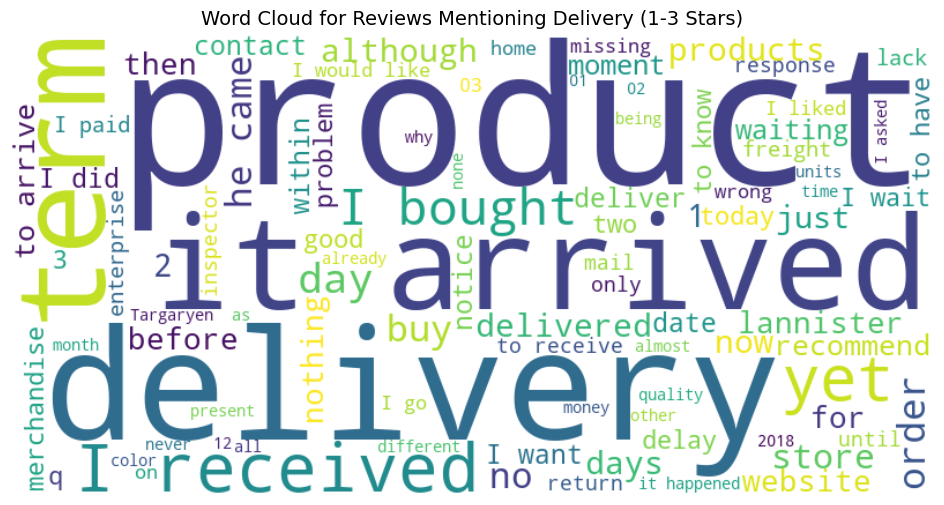

In [ ]:
# Define delivery-related keywords (in both Portuguese and English):
delivery_keywords = ['entregue', 'entrega', 'chegou', 'chegar', 'prazo', 'delivered', 'delivery', 'arrived', 'arrival']

# Step 2: Filter reviews that mention any of those keywords:
def contains_delivery_word(text):
    text = text.lower()
    return any(keyword in text for keyword in delivery_keywords)

delivery_related_reviews = low_reviews[low_reviews['full_comment'].astype(str).apply(contains_delivery_word)]

# Join and clean text:
all_delivery_text = ' '.join(delivery_related_reviews['full_comment'].dropna().astype(str).tolist())
delivery_words = re.findall(r'\b\w+\b', all_delivery_text.lower())

# Load stopwords:
stopwords_pt = set(stopwords.words('portuguese'))
stopwords_eng = set(stopwords.words('english'))
stop_words = stopwords_pt.union(stopwords_eng)

# Remove stopwords:
filtered_delivery_words = [word for word in delivery_words if word not in stop_words]

# Get most common words:
common_delivery_words = Counter(filtered_delivery_words).most_common(100)

# Translate with cache:
translator = GoogleTranslator(source='pt', target='en')
cache = {}
translated_common_delivery_words = []

for word, count in common_delivery_words:
    try:
        if word not in cache:
            cache[word] = translator.translate(word)
        translated_common_delivery_words.append((cache[word], count))
    except Exception:
        translated_common_delivery_words.append((word, count))

# Create word cloud:
translated_delivery_freq = dict(translated_common_delivery_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(translated_delivery_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Reviews Mentioning Delivery (1-3 Stars)", fontsize=14)
plt.show()

In [57]:
# Word frequency (translated, delivery-related low reviews):
for word, count in translated_common_delivery_words:
    print(f"{word}: {count}")

product: 3558
delivery: 2092
delivered: 1741
it arrived: 1612
term: 1431
I received: 1076
yet: 919
I bought: 911
day: 614
order: 515
buy: 490
no: 457
he came: 452
store: 429
now: 363
2: 353
days: 344
products: 336
although: 334
1: 333
delivered: 332
just: 320
then: 287
two: 285
for: 281
mail: 279
lannister: 275
before: 274
nothing: 267
website: 265
recommend: 254
to arrive: 250
waiting: 233
moment: 230
delay: 207
contact: 206
I want: 206
deliver: 203
within: 202
date: 199
notice: 197
other: 195
I did: 193
good: 186
delay: 183
delay: 180
to have: 180
good: 179
3: 178
merchandise: 177
I wait: 176
q: 176
today: 175
to know: 175
problem: 172
two: 171
freight: 168
enterprise: 165
lack: 165
I paid: 161
only: 149
response: 146
inspector: 141
until: 140
to receive: 140
return: 138
I would like: 134
mail: 134
I liked: 133
03: 130
missing: 128
on: 128
I go: 125
home: 124
time: 120
wrong: 120
it happened: 119
color: 118
none: 118
other: 117
month: 116
present: 116
quality: 116
being: 114
as: 114


In [40]:
# Total number of 1–3 star reviews:
total_low_reviews = len(low_reviews)

# Number of low reviews that mention delivery-related keywords:
delivery_issue_reviews = len(delivery_related_reviews)

# Percentage of low reviews mentioning delivery issues:
delivery_issue_percentage = (delivery_issue_reviews / total_low_reviews) * 100

print(f"Out of {total_low_reviews} low-rated reviews, {delivery_issue_reviews} mention delivery-related issues.")
print(f"That's approximately {delivery_issue_percentage:.2f}% of all 1-3 star reviews.")

NameError: name 'delivery_related_reviews' is not defined

## Univariate Analysis

In [41]:
df_reviews = df_reviews_delivered_cleaned.copy()

In [42]:
# Review score distribution:
fig = px.histogram(
    df_reviews,
    x='review_score',
    title='Review Score Distribution',
    color='review_score',
    category_orders={'review_score': [1, 2, 3, 4, 5]},
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.show()

In [43]:
# Comment length:
df_reviews['comment_length'] = df_reviews['review_comment_message'].astype(str).apply(len)

fig = px.histogram(
    df_reviews,
    x='comment_length',
    nbins=50,
    title='Length of Review Comments'
)
fig.show()

## Bivariate Analysis

In [44]:
# Review score vs comment length:
fig = px.box(
    df_reviews,
    x='review_score',
    y='comment_length',
    title='Comment Length by Review Score',
    color='review_score'
)
fig.show()

In [45]:
# Review score over time:
df_reviews['review_creation_date'] = pd.to_datetime(df_reviews['review_creation_date'])

fig = px.box(
    df_reviews,
    x=df_reviews['review_creation_date'].dt.month,
    y='review_score',
    title='Monthly Review Score Distribution',
    labels={'x': 'Month'}
)
fig.show()

In [46]:
# Make sure comment length and month are already computed:
df_reviews['comment_length'] = df_reviews['review_comment_message'].astype(str).apply(len)
df_reviews['month'] = pd.to_datetime(df_reviews['review_creation_date']).dt.to_period("M").astype(str)

# Count reviews per score per month:
low_score_summary = (
    df_reviews[df_reviews['review_score'].isin([1, 2, 3])]
    .groupby(['month', 'review_score'])
    .agg(count=('review_id', 'count'))
    .reset_index()
)

# Pivot to wide format:
highlight_table = low_score_summary.pivot(index='month', columns='review_score', values='count').fillna(0)

# Add a total low score column:
highlight_table['total_low_reviews'] = highlight_table.sum(axis=1)

# Sort by total_low_reviews:
highlight_table = highlight_table.sort_values(by='total_low_reviews', ascending=False)

In [47]:
# Display the top 10 months with the most low score reviews:
top_low_score_months = highlight_table.head(10)
top_low_score_months

review_score       1      2      3  total_low_reviews
month                                                
2018-03       1338.0  284.0  700.0             2322.0
2017-12        990.0  267.0  652.0             1909.0
2018-04        982.0  256.0  588.0             1826.0
2018-08        653.0  227.0  610.0             1490.0
2018-02        630.0  190.0  548.0             1368.0
2018-01        609.0  209.0  541.0             1359.0
2018-05        604.0  190.0  547.0             1341.0
2018-06        554.0  199.0  508.0             1261.0
2017-11        382.0  123.0  424.0              929.0
2018-07        385.0  123.0  384.0              892.0

In [48]:
# Prepare data for highlighting:
highlight_plot_data = low_score_summary.copy()
highlight_plot_data['review_score'] = highlight_plot_data['review_score'].astype(str)

fig = px.bar(
    highlight_plot_data,
    x='month',
    y='count',
    color='review_score',
    barmode='stack',
    title='Low Review Score Distribution by Month (1-3 Stars)',
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Reviews')
fig.show()

In [49]:
# Prepare data for highlighting all review scores (1 to 5)
all_score_summary = df_reviews.copy()  # Replace with your full review dataset
all_score_summary['review_score'] = all_score_summary['review_score'].astype(str)

# Group by month and review_score
all_score_plot_data = (
    all_score_summary
    .groupby(['month', 'review_score'])
    .size()
    .reset_index(name='count')
)

# Plot
fig = px.bar(
    all_score_plot_data,
    x='month',
    y='count',
    color='review_score',
    barmode='stack',
    title='Review Score Distribution by Month (1–5 Stars)',
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Number of Reviews'
)

fig.show()